In [2]:
#!pip install numpy scipy matplotlib

In [3]:
import numpy as np
from scipy.linalg import eigh_tridiagonal
import matplotlib.pyplot as plt
import matplotlib.animation as PillowWriter
from matplotlib import animation

#plt.style.use("seaborn-v0_8-colorblind") # Sorry ik ben kleurenblind dus ik moet speciale dingen hebben.

# Schroedinger met FDM

Zoals document al aangaf kan de Schroedingervergelijken numeriek opgelost worden door alles in een big ass tri-diagonale matrix te zetten en er een lineaire algebra opdracht van te maken.

$$
\begin{bmatrix}
\frac{1}{\Delta x'^2}+V'_1 & -\frac{1}{2 \Delta x'^2} &   0 & 0...\\
-\frac{1}{2 \Delta x'^2} & \frac{1}{\Delta x'^2}+V'_2 & -\frac{1}{2 \Delta y^2} & 0... \\
...& ... & ... & -\frac{1}{2 \Delta x^2}\\
...0 & 0 & -\frac{1}{2 \Delta x'^2} & \frac{1}{\Delta x'^2}+V'_{N-1}\\
\end{bmatrix} \cdot \begin{pmatrix}
\psi_1\\
\psi_2\\
\vdots\\
\psi_{N-1}
\end{pmatrix} = E' \begin{pmatrix}
\psi_1\\
\psi_2\\
\vdots\\
\psi_{N-1}
\end{pmatrix}
$$


Hier bij zijn: 

- $E' = \frac{m L^2}{\hbar^2} E$
- $V' = \frac{m L^2}{\hbar^2} V$
- $x' = \frac{x}{L}$

dimensieloze grootheden. Dit maakt echter voor het oplossen van $\psi$ niet uit, aangezien deze sowieso dimensieloos is.

Dus volgende dingen zijn nodig in python:

- een functie die het potentiaal definieerd.
- een functie die onze big ass lineaire algebra probleem oplost.

# Functie voor potentiaal

In [4]:
def V_p(x):

    # return np.zeros(len(x)) # Voor infinite square well

    return  100* ((x<=0.25) + (x>=0.75)).astype(float) # Voor finite square well

# Functie voor het lineaire algebra probleem

de tridiagonale matrix bestaat uit:
- 1 hoofddiagonaal
- 2 gelijke nevendiagonalen

Gelukkig of `scipy` en functie om eigenwaarde problemen van tridiagonale matrices op te lossen, dus gebruik ik die lekker. Dus het stappenplan wordt:

1. definieer de hoofdiagonaal
2. definieer de nevendiagonaal (deze hoeft maar 1 keer gedefinieerd te worden want de de nevendiagonalen moeten altijd gelijk zijn bij een tridiagonale matrix)
3. voer de diagonalen aan de eigenwaarden functie van `scipy` en let de magic happen
    - de `eigenh_tridiagonal` functie van `scipy` geeft de eigenwaarden en eigenvectoren uit in volgorde: eigenwaarden, eigenvectoren

In [5]:
def Schroedinger(x, dx):

    main = 1/(dx**2) + V_p(x)[1:-1]
    off = -1/(2*dx**2) * np.ones(len(main)-1) # lengte van de nevendiagonalen = lengte van hoofd - 1

    E, psi = eigh_tridiagonal(main, off) # psi word uitgegeven als een matrix waarbij elke kolomn een eigenvector is.

    return E, psi.T # psi wordt dmv psi.T getransponeerd, zodat elke vector 1 rij wordt.
                    # dit hoef je niet te doen maar ik vind het makkelijker met de syntex voor het plotten

# Berekening van eigenvectoren

Nu de functies al geschreven zijn is het makkelijk om de eigenwaarden en eigenvectoren te berekenen. Het enige wat moet gebeuren is dat $x$ en $dx$ gedefinieerd worden (dimensieloos), en dan worden ze aan de functie `Schroedinger` gevoerd.

Vergeet niet dat de randvoorwaarde voor $\psi$

$$\psi(0) = \psi(1) = 0$$

In [6]:
# Variabelen
N = 1000    # aantal gridpoints
dx = 1/N    # spacing van gridpoints
x = np.linspace(0, 1, N+1)

In [7]:
E, psi = Schroedinger(x, dx)

# Controle of $\psi$ genormaliseerd is

er kan getest worden op de normaliteit van $\psi$ door het inproduct te nemen, hierbij geld

$$\psi_i \cdot \psi_j = \delta_{ij}$$

inproduct kan in python met @.

In [8]:
psi[0]@psi[0] # bijna 1

1.0000000000000013

In [9]:
psi[0]@psi[1] # bijna 0

-7.895721449677351e-17

Nu de functie gerund heeft kunnen we kijken naar de eerste 3 energieniveaus. Pas op dat deze dimensieloos zijn, dus wat er uitgegeven wordt is

$$E'= \frac{mL^2E}{\hbar^2}$$

In [10]:
E[0:5]

array([ 11.93357488,  46.23944218,  96.24968015, 143.4681843 ,
       178.55539665])

Deze zijn dimensieloos, dus om de daadwerkelijke energie te krijgen:

$$ E = \frac{\hbar^2 E'}{m L^2} $$

maar dat doe ik niet want geeft weinig toegevoegde waarde. Je kan ook namelijk dimensieloos plotten.

# plotten van eerste 4 golffuncties

De amplitude van de golffunctie is met 2000 vermenigvuldigd, om de visualisatie beter te maken. Daarom wordt aanbevolen om naar het naar uiteindes te kijken en deze waarde te vergelijken met de hoogte van de put. 

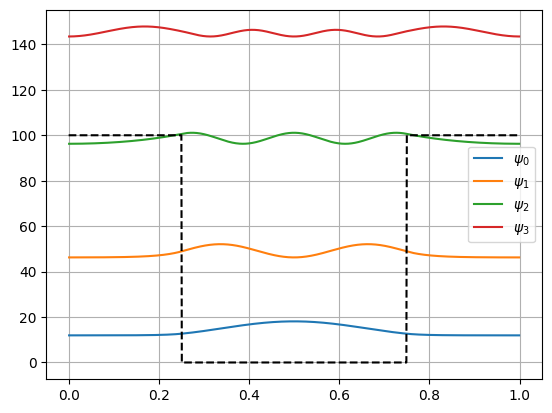

In [11]:

fig, ax = plt.subplots(1,1)
ax.grid(True)

for i in range(0,4):
    ax.plot(x[1:-1], np.abs(psi[i])**2*2000+(E[i]), label=("$\psi_{%i}$" %i))

ax.plot(x, V_p(x), 'k--')
# ax.set_yim([0, 18])

ax.legend()
plt.show()

In [12]:
np.max(V_p(x)), E[2]

(100.0, 96.24968014566375)

# Eerste vier waarschijnlijkheden

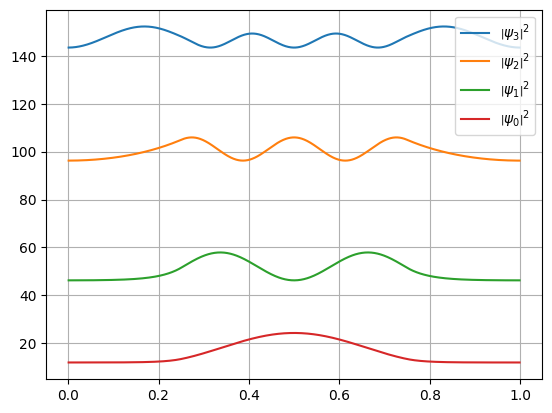

In [13]:
fig, ax = plt.subplots(1,1)
ax.grid(True)

i = 3
while i >= 0:
    ax.plot(x[1:-1], np.abs(psi[i])**2 * 4000 + E[i],  label=(r"$\left|\psi_{%i}\right|^2$" %i))
    i-=1
ax.legend(loc='upper right')
plt.show()

In [14]:
i = 3
while i >= 0:
    print(i)
    i-=1

3
2
1
0


# Energieniveaus plotten

Text(0.5, 0, '$n$')

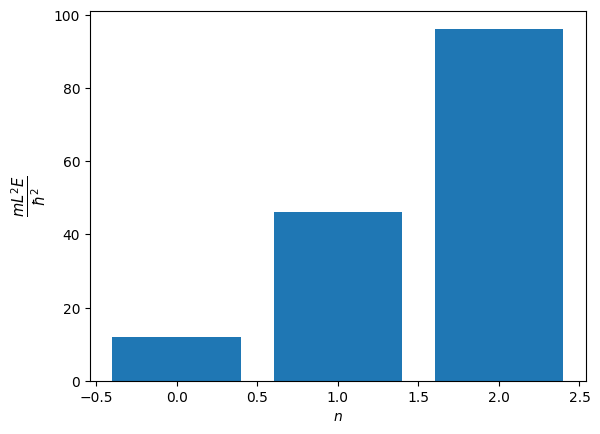

In [15]:
fig, ax = plt.subplots(1,1)

ax.bar(np.arange(0, 3), E[:3])
ax.set_ylabel(r"$\frac{m L^2 E}{\hbar^2}$", fontsize=15)
ax.set_xlabel(r"$n$")

# Animatie

In [16]:
t = np.linspace(0,2*np.pi/E[0], 120)
index = np.linspace(0,119,120)
time = np.exp(-1j*E[0]*t)


In [17]:
# find energies smaller than V(x)

j = [i for i in E if i < np.max(V_p(x))]

# find indeces for energies smaller than V(x)
ind_j = [E.tolist().index(j[i]) for i in range(len(j))]

    

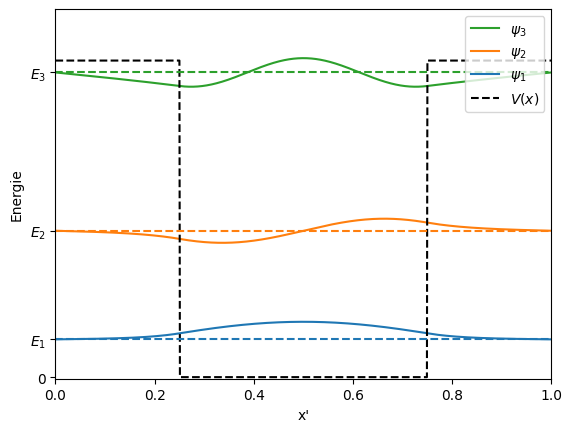

In [25]:
fig = plt.figure()
N = len(j)
ticks = [i for i in j]
ticks.insert(0, 0)
label = [(r"$E_%i$" % (j.index(i)+1)) for i in j]
label.insert(0, r"0")

#defining how the plot will look
plt.axes(xlim=(0, 1), ylim=(0-0.5, E[N-1]+20))
plt.xlabel("x'")
plt.ylabel('Energie')
plt.yticks(ticks, label)

#defining the mumber of wavefunctions shown
lines = [plt.plot([], [], label=(r"$\psi_{%i}$" % (_+1)))[0] for _ in range(N)] #lines to animate

patches = lines #things to animate

#plotting the defined potential in black dotted line
pot=plt.plot(x, V_p(x), 'k--', label=r'$V(x)$')

plt.gca().set_prop_cycle(None)
#plotting the energy levels
for l in np.linspace(0,N-1,N):
    plt.plot(x,np.zeros(len(x))+E[int(l)],'--')

def animate(i):
    #animate lines
    for k,line in enumerate(lines):
        time = np.exp(-1j*E[k]*t)
        psi_t = psi[k]*time[i]
        line.set_data(x[1:-1], np.real(psi_t*100)+E[k])
        
    return patches #return everything that must be updated

handles, labels = plt.gca().get_legend_handles_labels()
order = [j.index(i) for i in j]
order.reverse()
order.append(len(j))
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right')

anim = animation.FuncAnimation(fig, animate,
                                frames=len(t), interval=50, blit=True)

anim.save('finite.gif', fps=30, dpi=100)

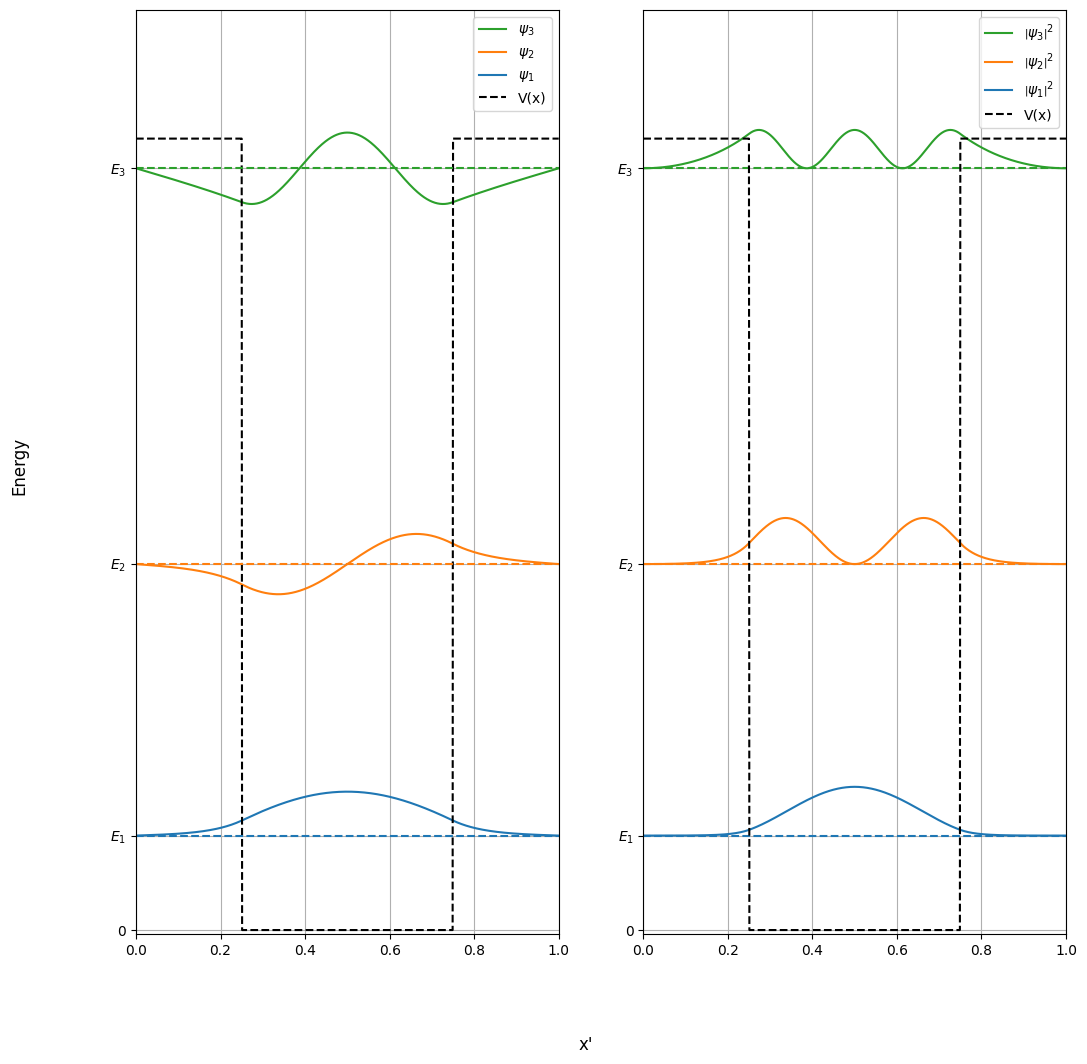

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))

#defining how the animted plot will look

fig.supxlabel("x'")
fig.supylabel('Energy')
ax1.grid(True)
ax2.grid(True)

ax1.set_yticks(ticks, label)
ax2.set_yticks(ticks, label)
ax1.set(xlim=(0, 1), ylim=(-0.5, E[N-1]+20))
ax2.set(xlim=(0, 1), ylim=(-0.5, E[N-1]+20))

#defining the mumber of wavefunctions shown
N = len(j)
lines = [ax1.plot([], [], label=(r"$\psi_{%i}$" % (_+1)))[0] for _ in range(N)] #lines to animate
patches = lines #things to animate

ax1.set_prop_cycle(None)


#plotting the defined potential in black dotted line
pot=ax1.plot(x, V_p(x), 'k--', label="V(x)")

#plotting the energy levels #AX1
for i in np.linspace(0,N-1,N):
    ax1.plot(x,np.zeros(len(x))+E[int(i)],'--')

# legend
handles, labels = ax1.get_legend_handles_labels()
order = [j.index(i) for i in j]
order.reverse()
order.append(len(j))
ax1.legend([handles[ind] for ind in order], [labels[ind] for ind in order], loc='upper right')

# def init():
#     #init linesb
#     for line in lines:
#         line.set_data([], [])

    # return patches #return everything that must be updated

def animate(i):
    #animate lines
    for k,line in enumerate(lines):
        time = np.exp(-1j*E[k]*t)
        psi_t = psi[k]*time[i]
        line.set_data(x[1:-1], np.real(psi_t)*100+E[k])
        
    return patches #return everything that must be updated


#plotting the psi^2 next to the animation

#AX2
for i in range(0,N):
    ax2.plot(x[1:-1], np.abs(psi[i])**2*2000+(E[i]), label=(r"$\left|\psi_{%i}\right|^2$" %(i+1)))

ax2.set_prop_cycle(None)

for i in np.linspace(0,N-1,N):
    ax2.plot(x,np.zeros(len(x))+E[int(i)],'--')

ax2.plot(x, V_p(x), 'k--', label="V(x)")

# legend

handles, labels = ax2.get_legend_handles_labels()
ax2.legend([handles[ind] for ind in order], [labels[ind] for ind in order], loc = 'upper right')

anim = animation.FuncAnimation(fig, animate,
                               frames=len(t), interval=50, blit=True)

anim.save('finite_prop.gif', fps=30, dpi=100)